Portfolio Optimisation

In [44]:
import yfinance as yf
import pandas as pd
import numpy as np
import datetime as dt
from scipy.optimize import minimize
import quantstats as qs
import matplotlib.pyplot as plt

MAXIMUM DRAWDOWN

In [45]:
chip_stocks = ['SPY', 'PDBC', 'GOVT']
START = dt.date.today() - dt.timedelta(days=365*2)
END = dt.date.today() + dt.timedelta(days=1)
chip_df = yf.download(chip_stocks, start=START, end=END,progress=False)

In [46]:
# Calculate daily returns
returns = chip_df['Adj Close'].pct_change().dropna()

# Calculate daily dollar volume
dollar_volume = chip_df['Volume'] * chip_df['Adj Close']

# Calculate the absolute returns
abs_returns = returns.abs()

# Calculate the Amihud illiquidity ratio
illiquidity_ratio = abs_returns / dollar_volume
factor=10e6
# Compute the average illiquidity ratio for each stock
avg_illiquidity_ratio = illiquidity_ratio.mean()*factor

Most Liquid Stocks (Lowest Illiquidity Ratio):
Ticker
SPY     0.000002
GOVT    0.000189
PDBC    0.001789
dtype: float64

Least Liquid Stocks (Highest Illiquidity Ratio):
Ticker
PDBC    0.001789
GOVT    0.000189
SPY     0.000002
dtype: float64


C:\Users\andre\AppData\Local\Temp\ipykernel_18268\4165959034.py:9: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_illiquidity_ratio = illiquidity_ratio.resample('M').mean()


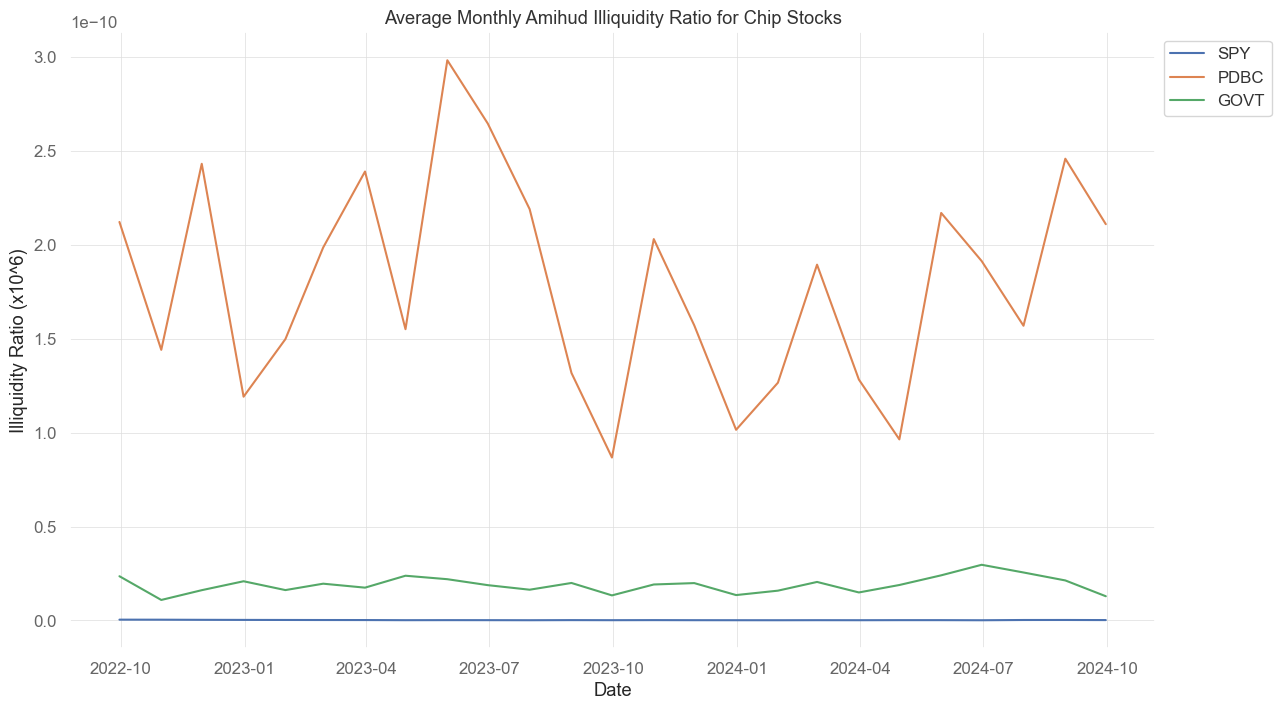

In [47]:
# Display the stocks with the lowest and highest illiquidity ratios

print("Most Liquid Stocks (Lowest Illiquidity Ratio):")
print(avg_illiquidity_ratio.nsmallest(10))

print("\nLeast Liquid Stocks (Highest Illiquidity Ratio):")
print(avg_illiquidity_ratio.nlargest(10))

monthly_illiquidity_ratio = illiquidity_ratio.resample('M').mean()

# Plot the monthly averages across time for each stock
plt.figure(figsize=(14, 8))
for stock in chip_stocks:
    if stock in monthly_illiquidity_ratio.columns:
        plt.plot(monthly_illiquidity_ratio.index, monthly_illiquidity_ratio[stock], label=stock)

plt.title('Average Monthly Amihud Illiquidity Ratio for Chip Stocks')
plt.xlabel('Date')
plt.ylabel('Illiquidity Ratio (x10^6)')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

In [48]:
# The follwing segment uses a composite score to construct a balanced portfolio:

# Calculate historical volatility (annualized standard deviation of daily returns)

volatility = returns.std() * np.sqrt(252)
print("Stocks volatility:\n")
print(volatility.sort_values())

# Normalize volatility and illiquidity ratio:

normalized_volatility = (volatility - volatility.mean()) / volatility.std()
normalized_illiquidity = (avg_illiquidity_ratio - avg_illiquidity_ratio.mean()) / avg_illiquidity_ratio.std()

# Combine normalized metrics into a composite score
composite_score = normalized_volatility + normalized_illiquidity

# Sort stocks by composite score (lower score indicates better combination of low volatility and high liquidity)
sorted_stocks = composite_score.sort_values()

print("Optimal Portfolio based on combined volatility and illiquidity:")
print(sorted_stocks)

Stocks volatility:

Ticker
GOVT    0.065526
SPY     0.150768
PDBC    0.158242
dtype: float64
Optimal Portfolio based on combined volatility and illiquidity:
Ticker
GOVT   -1.631198
SPY    -0.166637
PDBC    1.797835
dtype: float64


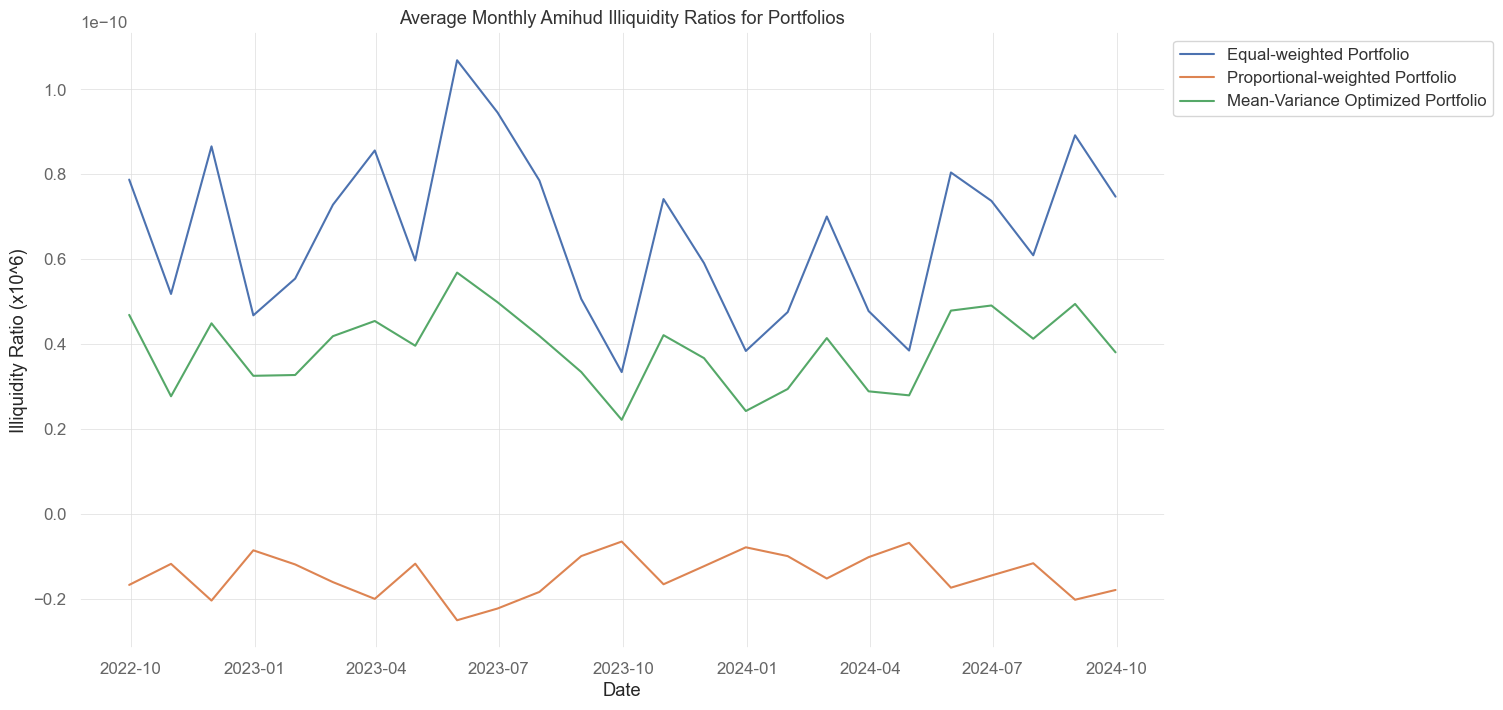

In [49]:
# Number of stocks to include in the portfolios
num_stocks = 3

# Select top N stocks with the lowest composite scores
selected_stocks = sorted_stocks.head(num_stocks).index
 # The following segment constructs two portfolios based on two weghting startegies:

# Construct equal-weighted portfolio
equal_weights = pd.Series(1/num_stocks, index=selected_stocks)

# Construct proportional-weighted portfolio (weights inversely proportional to composite scores)
proportional_weights = 1 / sorted_stocks.head(num_stocks)
proportional_weights /= proportional_weights.sum()
# Calculate weighted average monthly illiquidity ratios for the portfolios
equal_weighted_illiquidity = (monthly_illiquidity_ratio[selected_stocks] * equal_weights).sum(axis=1)
proportional_weighted_illiquidity = (monthly_illiquidity_ratio[selected_stocks] * proportional_weights).sum(axis=1)


'''
Liquidity Considerations: While the MVO portfolio focuses on return and volatility, it does not directly incorporate liquidity measures like the Amihud illiquidity ratio. By comparing the three portfolios, you can assess the impact of liquidity on portfolio performance.
'''

# Calculate mean-variance optimized portfolio weights
def get_mean_variance_weights(returns):
    def portfolio_volatility(weights, mean_returns, cov_matrix):
        return np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

    mean_returns = returns.mean()
    cov_matrix = returns.cov()
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)

    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0, 1) for asset in range(num_assets))
    initial_weights = num_assets * [1. / num_assets,]

    result = minimize(portfolio_volatility, initial_weights, args=args, method='SLSQP', bounds=bounds, constraints=constraints)
    return result.x

# Get the weights for the mean-variance optimized portfolio
mvo_weights = get_mean_variance_weights(returns[selected_stocks])
mvo_weights = pd.Series(mvo_weights, index=selected_stocks)
# Calculate weighted average monthly illiquidity ratios for the MVO portfolio
mvo_weighted_illiquidity = (monthly_illiquidity_ratio[selected_stocks] * mvo_weights).sum(axis=1)
# Plot the weighted average monthly Amihud illiquidity ratios
plt.figure(figsize=(14, 8))
plt.plot(equal_weighted_illiquidity.index, equal_weighted_illiquidity, label='Equal-weighted Portfolio')
plt.plot(proportional_weighted_illiquidity.index, proportional_weighted_illiquidity, label='Proportional-weighted Portfolio')
plt.plot(mvo_weighted_illiquidity.index, mvo_weighted_illiquidity, label='Mean-Variance Optimized Portfolio')

plt.title('Average Monthly Amihud Illiquidity Ratios for Portfolios')
plt.xlabel('Date')
plt.ylabel('Illiquidity Ratio (x10^6)')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True)
plt.show()

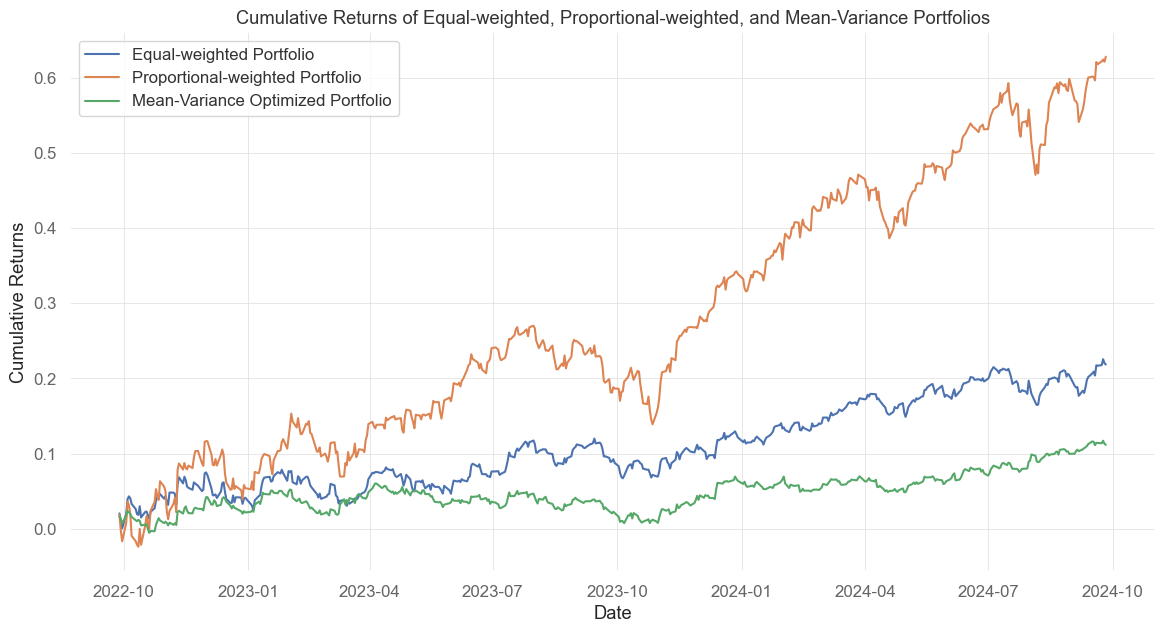

In [50]:
# Calculate daily portfolio returns for each portfolio
equal_weighted_returns = returns[selected_stocks].dot(equal_weights)
proportional_weighted_returns = returns[selected_stocks].dot(proportional_weights)
mvo_weighted_returns = returns[selected_stocks].dot(mvo_weights)

# Calculate cumulative returns for each portfolio
equal_weighted_cumulative = (1 + equal_weighted_returns).cumprod() - 1
proportional_weighted_cumulative = (1 + proportional_weighted_returns).cumprod() - 1
mvo_weighted_cumulative = (1 + mvo_weighted_returns).cumprod() - 1

# Plot cumulative returns
plt.figure(figsize=(14, 7))
plt.plot(equal_weighted_cumulative, label='Equal-weighted Portfolio')
plt.plot(proportional_weighted_cumulative, label='Proportional-weighted Portfolio')
plt.plot(mvo_weighted_cumulative, label='Mean-Variance Optimized Portfolio')
plt.title('Cumulative Returns of Equal-weighted, Proportional-weighted, and Mean-Variance Portfolios')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.grid(True)
plt.show()

In [51]:
def annualize_metrics(returns, trading_days_per_year=252):
    """
    Calculates annualized mean return and volatility (standard deviation) from daily returns.

    Args:
        returns (np.ndarray or pd.Series): Array or Series of daily returns.
        trading_days_per_year (int, optional): Number of trading days in a year. Defaults to 252.

    Returns:
        float: Annualized mean return.
        float: Annualized volatility (standard deviation).
    """
    mean_return = np.mean(returns)
    volatility = np.std(returns)

    annualized_mean_return = mean_return * trading_days_per_year
    annualized_volatility = volatility * np.sqrt(trading_days_per_year)

    return annualized_mean_return, annualized_volatility

# Example usage:
equal_annualized_mean, equal_annualized_volatility = annualize_metrics(equal_weighted_returns)

proportional_annualized_mean, proportional_annualized_volatility = annualize_metrics(proportional_weighted_returns)

mvo_annualized_mean,mvo_annualized_volatility = annualize_metrics(mvo_weighted_returns)

print("Annualized Metrics:")
print(f"Equal weights Portfolio:")
print(f"Annualized Mean Return: {equal_annualized_mean:.4f}")
print(f"Annualized Volatility: {equal_annualized_volatility:.4f}\n")

print(f"Proportional weights Portfolio:")
print(f"Annualized Mean Return: {proportional_annualized_mean:.4f}")
print(f"Annualized Volatility: {proportional_annualized_volatility:.4f}\n")

print(f"Mean_varaince Portfolio:")
print(f"Annualized Mean Return: {mvo_annualized_mean:.4f}")
print(f"Annualized Volatility: {mvo_annualized_volatility:.4f}\n")
'''
Performance Metrics: Evaluating the cumulative returns, volatility, and other risk measures (e.g., Sharpe ratio, Omega ratio, CVaR) for the three portfolios provides a comprehensive understanding of their performance under different optimization criteria.
'''
def calculate_risk_measures(daily_returns, label):
       sharpe_ratio = qs.stats.sharpe(daily_returns, rf=.054, periods=252, annualize=True)
       omega_ratio = qs.stats.omega(daily_returns.to_frame(), required_return=0, rf=.054, periods=252)

# Expected shortfall - Conditional Value at Risk
       cvar = qs.stats.conditional_value_at_risk(daily_returns, sigma=1, confidence=0.99)
       print(f"{label} Portfolio:")
       print(f"  Sharpe ratio: {sharpe_ratio}")
       print(f"  Omega ratio: {omega_ratio}")
       print(f"  CVaR: {cvar}\n")
  
calculate_risk_measures(equal_weighted_returns, "Equal weights ")
calculate_risk_measures(proportional_weighted_returns, "Proprtional weights ")
calculate_risk_measures(mvo_weighted_returns, "Mean-variance ")

Annualized Metrics:
Equal weights Portfolio:
Annualized Mean Return: 0.1031
Annualized Volatility: 0.0876

Proportional weights Portfolio:
Annualized Mean Return: 0.2557
Annualized Volatility: 0.1465

Mean_varaince Portfolio:
Annualized Mean Return: 0.0549
Annualized Volatility: 0.0592

Equal weights  Portfolio:
  Sharpe ratio: 0.5757754779269372
  Omega ratio: 1.1006010148000402
  CVaR: -0.014362623836195266

Proprtional weights  Portfolio:
  Sharpe ratio: 1.384678650261188
  Omega ratio: 1.2633980901031985
  CVaR: -0.024369665967967264

Mean-variance  Portfolio:
  Sharpe ratio: 0.03806844088333728
  Omega ratio: 1.0062915371627965
  CVaR: -0.009125463484701803

